In [1]:
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.read_csv('data/loan_data.csv')
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleaning

In [2]:
df.drop('SK_ID_CURR', axis=1, inplace=True)
df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash loans': 0, 'Revolving loans': 1})
# fill XNA with majority class (F)
df['CODE_GENDER'] = df['CODE_GENDER'].map({'F': 0, 'XNA': 0, 'M': 1})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})
df.dropna(inplace=True)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve, cohen_kappa_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from yellowbrick.classifier.rocauc import roc_auc
from mlxtend.plotting import plot_confusion_matrix as mlx_plot_cm
from imblearn.over_sampling import BorderlineSMOTE

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('TARGET', axis=1),
                                                    df['TARGET'],
                                                    stratify=df['TARGET'],
                                                    random_state=42)

Get baseline accuracy for comparison.

In [5]:
df['TARGET'].value_counts() / df.shape[0]

0    0.919263
1    0.080737
Name: TARGET, dtype: float64

In [6]:
sk_lr = LogisticRegressionCV(max_iter=1000)
sk_lr.fit(x_train, y_train)
test_predictions = sk_lr.predict(x_test)
print(sk_lr.C_)
print(sk_lr.score(x_test, y_test))

[0.0001]
0.9192641199906257


In [7]:
cohen_kappa_score(y_test, test_predictions)

0.0

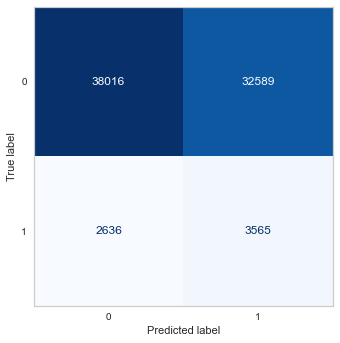

In [47]:
plot_confusion_matrix(sk_lr, x_test, y_test, cmap='Blues', colorbar=False)
plt.grid(b=None)

Just like with our demo problem, the model is predicting all values as non-defaults.

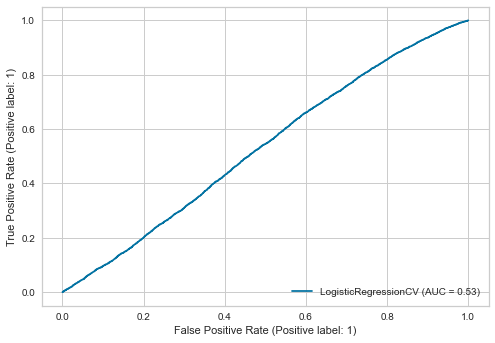

In [9]:
sk_roc = plot_roc_curve(sk_lr, x_test, y_test, drop_intermediate=False)

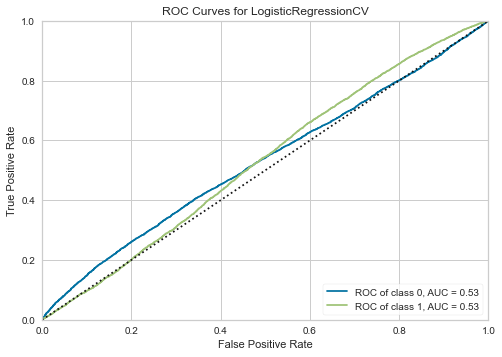

In [10]:
roc = roc_auc(sk_lr, x_test, y_test, macro=False, micro=False)

In [11]:
roc.roc_auc

{1: 0.5303594725527535, 0: 0.5303594725527535}

In [12]:
youdens_j_idx = np.argmax(sk_roc.tpr - sk_roc.fpr)
thresholds = np.unique(np.array([1] + list(sk_lr.predict_proba(x_test)[:, 1])))
thresholds.sort()
thresholds = thresholds[::-1]
thresh = thresholds[youdens_j_idx]
thresh

0.07409308324879196

In [13]:
youden_predictions = sk_lr.predict_proba(x_test)[:, 1] >= thresh

In [14]:
print(classification_report(y_test, youden_predictions))

              precision    recall  f1-score   support

           0       0.93      0.41      0.56     70605
           1       0.09      0.66      0.16      6201

    accuracy                           0.43     76806
   macro avg       0.51      0.53      0.36     76806
weighted avg       0.86      0.43      0.53     76806



(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

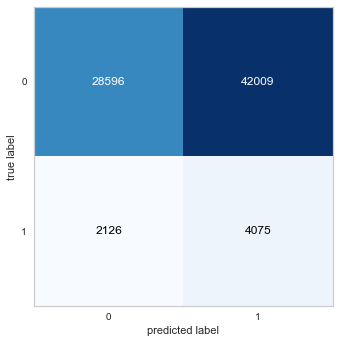

In [15]:
mlx_plot_cm(confusion_matrix(y_test, youden_predictions))

In [16]:
sm_lr = sm.Logit(y_train, sm.add_constant(x_train))
sm_results = sm_lr.fit()
sm_results.summary()

Optimization terminated successfully.
         Current function value: 0.275062
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               230415
Model:                          Logit   Df Residuals:                   230405
Method:                           MLE   Df Model:                            9
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:                 0.01962
Time:                        17:17:26   Log-Likelihood:                -63378.
converged:                       True   LL-Null:                       -64647.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3990      0.022   -109.064      0.000      -2.442      -2.356
NAME_CONTRACT_TYPE    -0.3406      0.033    -10.468      0.000      -0.404      -0.277
CODE_GENDER            0.5019      0.017     30.074      0.000       0.469       0.535
FLAG_OWN_CAR          -0.3408      0.018    -18.981      0.000      -0.376      -0.306
FLAG_OWN_REALTY       -0.0624      0.017     -3.755      0.000      -0.095      -0.030
CNT_CHILDREN           0.0881      0.010      8.687      0.000       0.068       0.108
AMT_INCOME_TOTAL    6.172e-09   2.18e-08      0.284      0.777   -3.65e-08    4.88e-08
AMT_CREDIT              3e-06   1.24e-07     24.146      0.000    2.76e-06    3.24e-06
AMT_ANNUITY         9.046e-06   8.69e-07     10.404      0.000    7.34e-06    1.07e-05
AMT_GOODS_PRICE    -4.012e-06   1.43e-07    -28.031      0.000   -4.29e-06   -3.73e-06
======================================================================================
"""

It looks like the one variable we could throw out is the income column since it has such a larg p-value of 0.777. However, this is without regularization. Confusingly, with regularization, we find other columns have high p-values. For now we will keep all columns.

In [17]:
reg_res = sm_lr.fit_regularized()
reg_res.summary()

C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4180441204360345
            Iterations: 170
            Function evaluations: 1479
            Gradient evaluations: 170


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               230415
Model:                          Logit   Df Residuals:                   230405
Method:                           MLE   Df Model:                            9
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:                 -0.4900
Time:                        17:17:45   Log-Likelihood:                -96324.
converged:                       True   LL-Null:                       -64647.
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2865      0.042     -6.876      0.000      -0.368      -0.205
NAME_CONTRACT_TYPE    -0.0703      0.041     -1.698      0.089      -0.151       0.011
CODE_GENDER            0.0644      0.029      2.239      0.025       0.008       0.121
FLAG_OWN_CAR          -0.0285      0.030     -0.940      0.347      -0.088       0.031
FLAG_OWN_REALTY       -0.1739      0.027     -6.504      0.000      -0.226      -0.121
CNT_CHILDREN           0.0118      0.017      0.691      0.490      -0.022       0.045
AMT_INCOME_TOTAL   -6.038e-06   2.64e-07    -22.837      0.000   -6.56e-06   -5.52e-06
AMT_CREDIT          4.641e-06   3.77e-07     12.310      0.000     3.9e-06    5.38e-06
AMT_ANNUITY        -9.086e-06   2.74e-06     -3.319      0.001   -1.45e-05   -3.72e-06
AMT_GOODS_PRICE     -1.17e-05   4.77e-07    -24.551      0.000   -1.26e-05   -1.08e-05
======================================================================================
"""

In [18]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)
print(knn.score(x_test, y_test))
print(cohen_kappa_score(y_test, knn_predictions))

0.9129495091529307
0.019744735130717728


In [19]:
ss = StandardScaler()
x_tr_sc = ss.fit_transform(x_train)
x_te_sc = ss.transform(x_test)

knn_sc = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_sc.fit(x_tr_sc, y_train)
knn_predictions = knn_sc.predict(x_te_sc)
print(knn.score(x_te_sc, y_test))
print(cohen_kappa_score(y_test, knn_predictions))

0.9192641199906257
0.015712243292260286


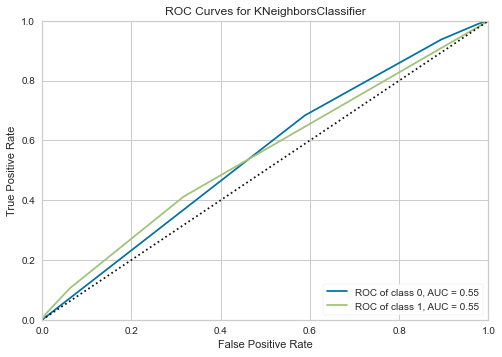

AttributeError: 'KNeighborsClassifier' object has no attribute 'binary'

AttributeError: 'KNeighborsClassifier' object has no attribute 'binary'

In [20]:
roc_auc(knn, x_test, y_test, macro=False, micro=False)

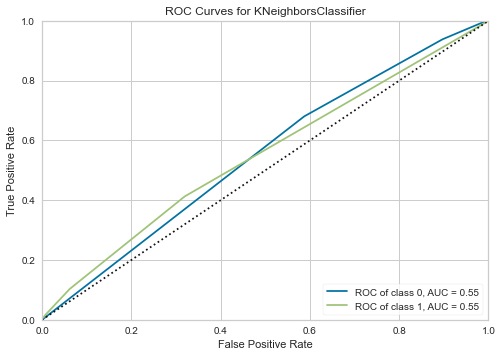

AttributeError: 'KNeighborsClassifier' object has no attribute 'binary'

AttributeError: 'KNeighborsClassifier' object has no attribute 'binary'

In [21]:
roc_auc(knn_sc, x_te_sc, y_test, macro=False, micro=False)

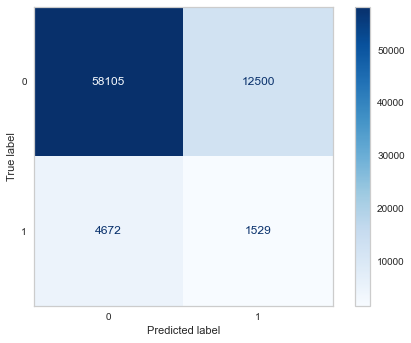

In [48]:
plot_confusion_matrix(knn, x_test, y_test, cmap='Blues')
plt.grid(b=None)

KNN does a better job of predicting more of a balance of classes, and has a slightly better Cohen's Kappa than the logistic regression model. The AUC scores are about the same. Scaling does not seem to change results much, although it would be better to only scale the numeric columns and not categorical ones.

In [23]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
gnb_predictions = gnb.predict(x_test)
print(gnb.score(x_test, y_test))
print(cohen_kappa_score(y_test, gnb_predictions))

0.9125979741166055
-0.003081483556648834


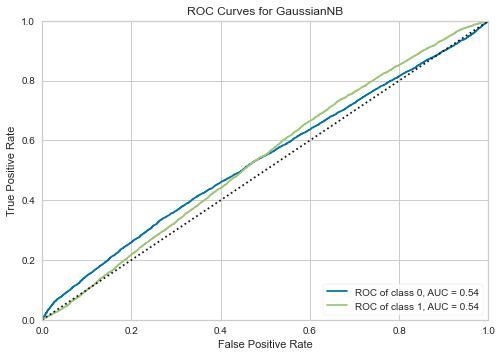

AttributeError: 'GaussianNB' object has no attribute 'binary'

AttributeError: 'GaussianNB' object has no attribute 'binary'

In [24]:
roc_auc(gnb, x_test, y_test, macro=False, micro=False)

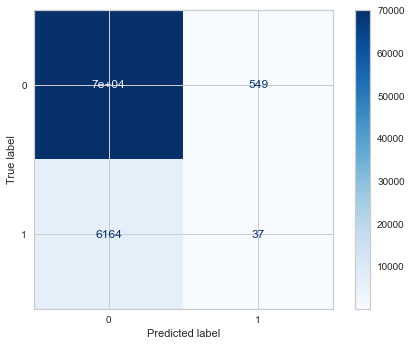

In [25]:
plot_confusion_matrix(gnb, x_test, y_test, cmap='Blues')

Naive Bayes performs the worst here. We will try resampling and see if that improves LR and KNN at all.

In [26]:
smote = BorderlineSMOTE(random_state=42)
x_tr_resamp, y_tr_resamp = smote.fit_resample(x_train, y_train)

In [27]:
sk_lr = LogisticRegressionCV(max_iter=1000)
sk_lr.fit(x_tr_resamp, y_tr_resamp)
test_predictions = sk_lr.predict(x_test)
print(sk_lr.C_)
print(sk_lr.score(x_test, y_test))
print(cohen_kappa_score(y_test, test_predictions))

[10000.]
0.5413769757571023
0.03538474357108368


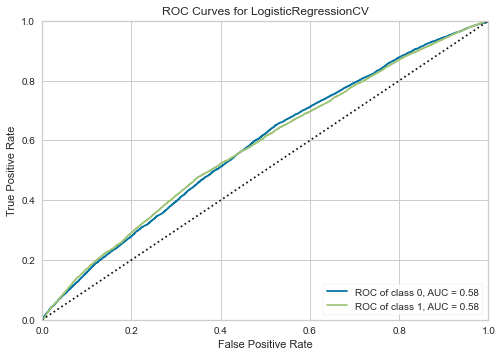

In [28]:
lr_roc = roc_auc(sk_lr, x_test, y_test, macro=False, micro=False)

In [29]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(x_tr_resamp, y_tr_resamp)
knn_predictions = knn.predict(x_test)
print(knn.score(x_test, y_test))
print(cohen_kappa_score(y_test, knn_predictions))

0.7764237168971174
0.04412609836153947


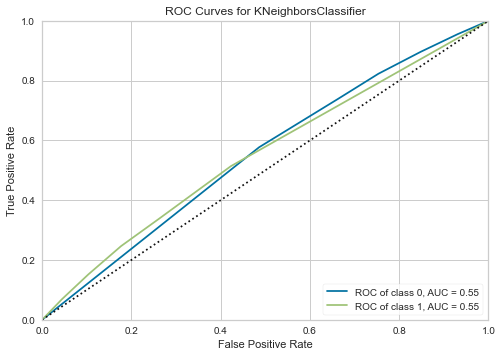

In [30]:
knn_roc = roc_auc(knn, x_test, y_test, macro=False, micro=False)

In [31]:
thresholds

array([1.00000000e+00, 4.14396525e-01, 4.12284400e-01, ...,
       5.40824152e-15, 3.90532242e-17, 2.12461987e-61])

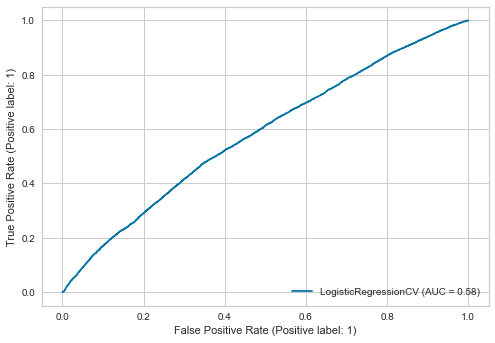

In [32]:
lr_roc_sk = plot_roc_curve(sk_lr, x_test, y_test, drop_intermediate=False)

In [33]:
youdens_j_idx = np.argmax(lr_roc_sk.tpr - lr_roc_sk.fpr)
thresholds = np.unique(np.array([1.1] + list(sk_lr.predict_proba(x_test)[:, 1])))
thresholds.sort()
thresholds = thresholds[::-1]
thresh = thresholds[youdens_j_idx]
thresh

0.5166663210387787

In [34]:
youden_predictions = sk_lr.predict_proba(x_test)[:, 1] >= thresh

Confirm the TP/FP measures are correct with the Youden's J optimal threshold:

In [35]:
lr_roc_sk.tpr[youdens_j_idx]

0.47685857119819386

In [36]:
lr_roc_sk.fpr[youdens_j_idx]

0.3487430068692019

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, youden_predictions).ravel()

In [38]:
tp / (tp + fn)

0.47685857119819386

In [39]:
fp / (fp + tn)

0.3487430068692019

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

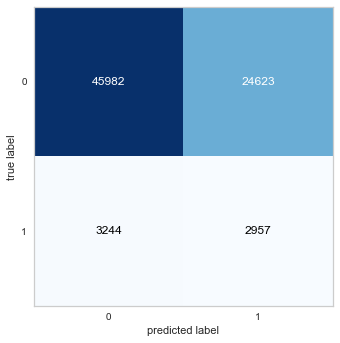

In [40]:
mlx_plot_cm(confusion_matrix(y_test, youden_predictions))

In [41]:
print(classification_report(y_test, youden_predictions))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77     70605
           1       0.11      0.48      0.18      6201

    accuracy                           0.64     76806
   macro avg       0.52      0.56      0.47     76806
weighted avg       0.87      0.64      0.72     76806



In [42]:
print(cohen_kappa_score(y_test, youden_predictions))

0.0498032030405533


In [43]:
sm_lr = sm.Logit(y_tr_resamp, x_tr_resamp)
reg_res = sm_lr.fit_regularized(alpha=1/10000)
reg_res.summary()

C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6320309205654274
            Iterations: 38
            Function evaluations: 73
            Gradient evaluations: 38


C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 9 out of 9 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:               423624
Model:                          Logit   Df Residuals:                   423615
Method:                           MLE   Df Model:                            8
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:                 0.08817
Time:                        17:19:37   Log-Likelihood:            -2.6774e+05
converged:                       True   LL-Null:                   -2.9363e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
NAME_CONTRACT_TYPE     0.1263      0.013      9.786      0.000       0.101       0.152
CODE_GENDER           -0.0989      0.008    -12.690      0.000      -0.114      -0.084
FLAG_OWN_CAR          -1.1401      0.009   -129.244      0.000      -1.157      -1.123
FLAG_OWN_REALTY       -0.5773      0.006    -92.037      0.000      -0.590      -0.565
CNT_CHILDREN          -0.3071      0.005    -56.967      0.000      -0.318      -0.297
AMT_INCOME_TOTAL    1.269e-06   4.15e-08     30.561      0.000    1.19e-06    1.35e-06
AMT_CREDIT          4.783e-06   5.42e-08     88.267      0.000    4.68e-06    4.89e-06
AMT_ANNUITY         3.504e-05   4.03e-07     86.850      0.000    3.42e-05    3.58e-05
AMT_GOODS_PRICE    -6.426e-06   6.09e-08   -105.484      0.000   -6.55e-06   -6.31e-06
======================================================================================
"""

Loan default data with a binary target (1 for default, 0 for no default) was modeled with machine learning. We found a logistic regression model to work best for predicting the target from features. All features were found to be relevant to the target with p-values (small p-values less than 0.05). It was found oversampling the data with SMOTE improved the AUC score from 0.53 to 0.58  for logistic regression. KNN did not seem to benefit from oversampling, with an AUC score of 0.55. A Gaussiain Naive Bayes model was also tried, but found to have worse performance than KNN and logistic regression. The Youden's J method was used to optimize the cutoff threshold for predictions, resulting in a final accuracy of 85% compared with a no information rate of 92%. Although the accuracy is not better than guessing all values are no default, the true positive rate was 48%. This means we are getting 50% of the actual defaulted loans correctly classified, which is not bad. It also means we have a roughly 50% false negative rate, so we are missing half of the defaulted loans in our classifier. More features that more strongly correlate to the target could help to improve accuracy, as well as collecting more data.